In [1]:
%matplotlib inline
import numpy as np

import matplotlib.pyplot as plt

# sample a random distribution
d50 = 10/1e6

a50 = d50/2
std = 1

number_of_particles = 1e6
mean = np.log(a50)
radii = np.random.lognormal(mean, std, int(number_of_particles))


# set sediment density
density = 2650  # kg/m**3

# calculate the mass concentration assuming unit volume
particle_masses = 4/3*np.pi*density*radii**3
mass_concentration = np.sum(particle_masses)  # kg/m**3
mass_concentration*1e3  # mg/L

0.11507601674826951

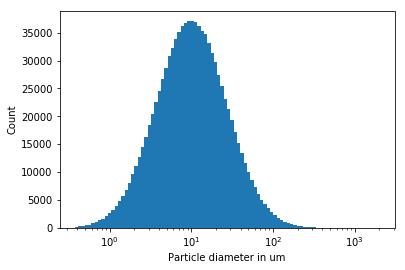

In [2]:
# bin the radii using lab bins
bin_edges = np.logspace(np.log10(0.375124), np.log10(2000), num=93)/2/1e6
particle_count, bin_edges = np.histogram(radii, bins=bin_edges)

bin_widths = np.diff(bin_edges)
_ = plt.bar(2*bin_edges[:-1]*1e6, particle_count, 2*bin_widths*1e6, align='edge')
plt.xscale('log')
_ = plt.xlabel('Particle diameter in um')
_ = plt.ylabel('Count')

In [19]:
from said.sedimentacousticdistribution import scattering_attenuation_coefficient, viscous_attenuation_coefficient

frequency = 1200  # kHz

sac = scattering_attenuation_coefficient(2*radii, frequency, density/1000)
vac = viscous_attenuation_coefficient(2*radii, frequency, density/1000)
particle_attenuation = particle_masses*(sac + vac)
particle_attenuation.sum()

1.0375265080852451e-05

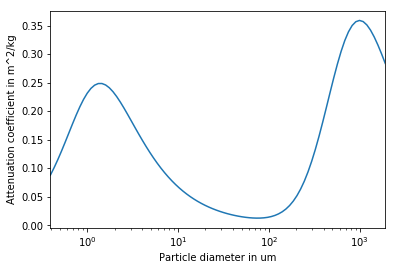

In [22]:
bin_centers = (bin_edges[1:] + bin_edges[:-1])/2
bin_masses = 4/3*np.pi*density*bin_centers**3

bin_sac = scattering_attenuation_coefficient(2*bin_centers, frequency, density/1000)
bin_vac = viscous_attenuation_coefficient(2*bin_centers, frequency, density/1000)
plt.plot(2*bin_centers*1e6, bin_sac+bin_vac)
plt.xlabel('Particle diameter in um')
plt.ylabel('Attenuation coefficient in m^2/kg')
plt.xscale('log')
plt.autoscale(axis='x', tight=True)

In [23]:
bin_attenuation = bin_masses*(bin_sac + bin_vac)*particle_count
bin_attenuation.sum()

1.0554188448742594e-05

In [25]:
from said.sedimentacousticdistribution import SedimentAcousticDistribution
from said.sedimentsizedistribution import SedimentSizeDistribution

# convert to volume CDF
bin_particle_volumes = 4/3*np.pi*bin_centers**3
bin_volumes = particle_count*bin_particle_volumes
cumulative_volume = np.cumsum(bin_volumes)
cumulative_volume = np.insert(cumulative_volume, 0, 0)
volume_cdf = cumulative_volume/np.sum(bin_volumes)

# initialize a SedimentSizeDistribution class and get the number CDF
sediment_size_distribution = SedimentSizeDistribution(2*bin_edges, volume_cdf)

mean_sediment_ac = SedimentAcousticDistribution(sediment_size_distribution).sediment_attenuation_coefficient(frequency)
mass_concentration*mean_sediment_ac

1.0460895768800327e-05